<a href="https://www.kaggle.com/code/sumaiyakawsar/tumour-classification-vgg16-vgg19-inceptionr?scriptVersionId=212400365" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Brain Tumour Classification using VGG16, VGG19 and InceptionResNetV2

In this project, we utilize deep learning techniques to classify brain tumours based on medical imaging data, leveraging three powerful Convolutional Neural Networks (CNNs): **VGG16**, **VGG19**, and **InceptionResNetV2**. Each of these models has been pre-trained on large datasets like ImageNet, making them excellent starting points for transfer learning tasks. 

# Step 1: Import Libraries

In [1]:
# Import Data Science Libraries
import numpy as np
import tensorflow as tf
import os
import warnings
import pandas as pd
from tabulate import tabulate

# Tensorflow Libraries
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, MaxPooling2D
from keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.utils import plot_model
from keras import activations, Input, Model, initializers
from keras.optimizers import Adam
# Callbacks/Metrics
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image, ImageFile
import seaborn as sns

%matplotlib inline

from warnings import filterwarnings

filterwarnings('ignore')
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
tf.__version__# 2.14.0

'2.16.1'

# Step Bonus: Functions to Reuse

In [3]:
def image_path(image_name):
    """Returns the full path of an image given its name."""
    if not os.path.exists(images_dir):
        os.makedirs(images_dir)
    return os.path.join(images_dir, image_name)

def model_path(model_name):
    """Returns the full path of a model given its name."""
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    return os.path.join(model_dir, model_name)

In [4]:
def plot_metric(history, m_name):
    """Plots training and validation accuracy/loss curves."""
    fig, ax = plt.subplots(1,2,figsize=(14,7))
    
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_accuracy) + 1)

    # Plot accuracy
    ax[0].plot(epochs, train_accuracy, marker='o', label='training_accuracy')
    ax[0].plot(epochs, val_accuracy, marker='o', label='val_accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].legend()
    
    #Save image
    #plt.savefig(image_path("Training and validation accuracy_"+m_name+".png"))

    # Plot loss
    ax[1].plot(epochs, train_loss,marker='o', label='training_loss')
    ax[1].plot(epochs, val_loss,marker='o',label='val_loss')
    ax[1].set_xlabel('Epochs')
    ax[1].legend()
    
    fig.suptitle(f"Training and validation Accuracy/Loss_{m_name}", fontsize=16)

    #Save image
    #plt.savefig(image_path("Training and validation loss_"+m_name+".png"))
    plt.show()

In [5]:
def create_model(pre_trained_model, p_name):
    """
    Define a function to create the Sequential model with a pre-trained base model and additional layers.

    Parameters:
    pre_trained_model (Model): A pre-trained model to be used as the base.
    p_name (str): Name suffix for the model.

    Returns:
    Model: Custom sequential model with the pre-trained base model and additional layers.
    """
    # Instantiate the sequential model and add the model:
    model = Sequential(name=main_model_name+p_name)
    model.add(pre_trained_model)                          # Add the pre-trained model as a layer to the Sequential model

    model.add(GlobalAveragePooling2D(name="pooling_1"))   # Add a Global Average Pooling 2D layer
    model.add(Flatten())                                  # Flatten the input to a 1D array before passing it to the next layer
    model.add(Dense(60, activation='relu'))               # Add a fully connected Dense layer with 60 units and ReLU activation function
    model.add(Dropout(0.2, name='dropout_1'))             # Apply dropout with a rate of 0.2 to prevent overfitting

    model.add(Dense(no_classes, activation='softmax', name='predictions'))  # Add the output layer with softmax activation
    model.build()

    return model

In [6]:
def display_image(image, title, subplot, color):
  """
    Display a single image with a title in a specific subplot.

    Parameters:
    image (array-like): The image to be displayed.
    title (array-like): The title of the image.
    subplot (int): The position of the subplot.
    color (str): The color of the title.
  """
  plt.subplot(subplot)                      # Create a subplot at the specified position
  plt.axis("off")                           # Turn off the axis display
  plt.imshow(image)                         # Display the image
  plt.title(title,fontsize=14,color=color)  # Set the title with the specified fontsize and color

In [7]:
def display_six_images(images,titles,image_name, title_colors=None):
  """
    Display six images in a 2x3 grid along with their titles and save the plot as an image.

    Parameters:
    images (list): List of six images to be displayed.
    titles (list): List of titles corresponding to the six images.
    image_name (str): The name to save the image as.
    title_colors (list, optional): List of colors for the titles. If not provided, default color is black.

    Returns:
    Plot with 6 images and titles
  """
  plt.figure(figsize=(10,10))                                     # Create a new figure with a specified size
  for i in range(6):
    color = 'black' if title_colors is None else title_colors[i]  # Set the title color based on the input or default
    display_image(images[i],titles[i],331+i,color)                # Display each image in the 2x3 grid
  plt.tight_layout()                                              # Adjust the layout for better spacing
  plt.subplots_adjust(wspace=0.1,hspace=0.1)                      # Adjust the space between subplots
  #plt.savefig(image_path(image_name+".png"))                      # Save the figure as an image with the provided name
  plt.show()                                                      # Display the plot

In [8]:
def count_images_per_class(generator):
  """
    Function to counts the number of images per class in a given data generator.

    Args:
    generator (ImageDataGenerator): A data generator object containing the images and their corresponding labels.

    Returns:
    dict: A dictionary where the keys are the class names and the values are the corresponding counts of images belonging to each class.
  """
  # Extracts the class indices from the generator
  class_indices = generator.class_indices

  # Initialize an empty dictionary to store the counts of images per class
  num_images_per_class = {}

   # Iterate through each class and its corresponding index
  for class_name, class_index in class_indices.items():
    num_images = len(generator.labels[generator.labels == class_index]) # Count the number of images belonging to the current class
    num_images_per_class[class_name] = num_images         # Store the count in the dictionary with the class name as the key
  return num_images_per_class                             # Return the dictionary containing the counts of images per class

In [9]:
def image_title(true_label,predicted_label):
  """
    Generate the title and color for an image based on its true label and predicted label.

    Args:
    true_label (numpy array): The true label of the image.
    predicted_label (numpy array): The predicted label of the image.

    Returns:
    tuple: A tuple containing the title (string) and color (string) of the image.
  """
  # Extract the index of the class with the highest probability from the true label
  class_idx=np.argmax(true_label,axis=-1)

  # Extract the index of the class with the highest probability from the predicted label
  prediction_idx = np.argmax(predicted_label,axis=-1)

  # Compare the indices to determine if the prediction is correct or not
  if class_idx==prediction_idx:
    # If the prediction is correct, return the predicted class name in the color green
    return f'{class_names[prediction_idx]} [correct]', 'green'
  else:
    # If the prediction is incorrect, return the predicted class name, the correct class name, in the color red
    return f'{class_names[prediction_idx]} [incorrect],\n should be {class_names[class_idx]}]','red'

In [10]:
def predict_titles(images,labels,model):
  """
    Generate titles and colors for a list of images based on their true labels and predictions.

    Args:
    images (list): List of images.
    labels (list): List of true labels for the images.
    model (object): The trained model used for prediction.

    Returns:
    tuple: A tuple containing the list of titles (strings) and list of colors (strings) for the images.
  """

  # Make predictions using the provided model
  predictions = model.predict(images)
  # Initialize empty lists to store titles and colors
  titles, colors =[],[]

  # Iterate through each label and its corresponding prediction
  for label,prediction in zip(classes, predictions):
    # Generate the title and color for each image based on its true label and predicted label
    title, color = image_title(label, prediction)
    titles.append(title)
    colors.append(color)
  # Return the generated titles and colors for the images
  return titles, colors

# Step 2: Data Preprocessing

Dataset = https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/data

## Load Data

In [11]:
# Setting the path to the training directory that contains the data for yoga asanas
train_dir = '/kaggle/input/brain-tumor-classification-mri/Training'

# Setting the path to the test directory that contains the data for yoga asanas
test_dir = '/kaggle/input/brain-tumor-classification-mri/Testing'

# Setting the path to the directory containing images for the assignment
images_dir = '/kaggle/working/Images'

# Setting the path to the directory where the trained models will be saved
model_dir = '/kaggle/working/Models'

In [12]:
#  list all the files in the directory and store them in 'class_names' alphabetically
class_names = sorted(os.listdir(train_dir))
print(f"Classes :{class_names}")

# number of classes present
no_classes = len(class_names)
print(f"Total Number of Classes : {no_classes}")

Classes :['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Total Number of Classes : 4


## Set Hyperparameters


In [13]:
h, w = 224, 224

# Set the batch size
batch_size = 30

# Set the number of epochs
epochs = 25

# Model Name
main_model_name = "Brain-Tumour-Classification"

## Data Augmentation 

For training deep learning models efficiently, especially with limited computational resources, we use data generators for training, validation, and testing. These generators feed batches of images to the model during training, allowing the model to scale with large datasets.

The `ImageDataGenerator` class is used to apply real-time data augmentation for the training set. This helps the model generalize better by artificially expanding the dataset with transformations. These transformations prevent the model from overfitting, especially when the dataset is limited.

1. Augmentation Parameters:

* `zoom_range=0.2`: This introduces random zooming of the images, within the range of -0.2 to 0.2. This helps the model learn to recognize tumours at different scales.
rotation_range=20: This randomly rotates the images by up to 20 degrees, ensuring that the model is robust to slight rotations of brain scans in real-world scenarios.
* `width_shift_range=0.1` and `height_shift_range=0.1`: These parameters allow for random horizontal and vertical shifts of the images by up to 10%, simulating the possibility of slight misalignments in the positioning of tumour scans.
* `horizontal_flip=True`: This randomly flips the images horizontally, which is crucial for ensuring the model does not develop biases toward certain orientations of the tumour.

2. Pixel Value Preprocessing:

* `rescale=1./255`: This rescales the pixel values of the images from the typical range of [0, 255] to [0, 1]. It is a standard practice in deep learning to normalize pixel values for better convergence and to prevent any single pixel value from dominating the gradient updates during training.
  
3. Validation Split:

* `validation_split=0.3`: This parameter ensures that 30% of the dataset is reserved for validation during training. The validation set is not seen by the model during training and is used to monitor its performance, helping to identify overfitting or underfitting.

In [14]:
# Initialize an instance of the ImageDataGenerator class and store it in the variable 'data_generator' with specified augmentations
data_generator = IDG(

    # Augmentation parameters:
    zoom_range=0.2,           
    rotation_range=20,        
    width_shift_range=0.1,    
    height_shift_range=0.1,   
    horizontal_flip=True,     

    # Pixel value preprocessing:
    rescale=1./255,           
    # Validation data splitting:
    validation_split=0.2    
)

test_data_generator = IDG( 
    rescale=1./255       
)

After defining the augmentation settings, the code proceeds to create three different data generators: one for training, one for validation, and one for testing. These generators fetch data from their respective directories and prepare it for model training.

1. Training Generator (`train_generator`):

* The `flow_from_directory` method is called with the train_dir directory, which contains subdirectories representing different tumour categories. This method automatically labels the data based on the folder names.
* `target_size=(h,w)`: Resizes all images to a consistent shape (h,w) for input to the neural network.
* `color_mode='rgb'`: Specifies that the images are in RGB color mode (three channels for red, green, and blue).
* `class_mode='categorical'`: Since this is a multi-class classification problem, categorical encoding is used for the labels (one-hot encoded).
* `batch_size=batch_size`: Defines the number of images per batch. This is typically chosen based on memory constraints and can impact the efficiency of training.
* `subset="training"`: Specifies that this generator will load data specifically for training.

2. Validation Generator (`validation_generator`):

* This is similar to the training generator but works with the validation subset of the data (subset="validation"). The validation data is used to evaluate the model during training and helps tune hyperparameters.

3. Testing Generator (`test_generator`):

* The testing generator loads the test data from the test_dir. This data will not be used during training or validation but will be used to evaluate the final performance of the model after training.

In [15]:
# Create a generator for training data from training directory
train_generator =  data_generator.flow_from_directory(train_dir,                # Directory path for training data
                                                    target_size = (h,w),        # Reshape images to the specified dimensions
                                                    color_mode = 'rgb',         # Color mode set to RGB
                                                    class_mode = 'categorical', # Use categorical labels
                                                    batch_size = batch_size,    # Set the batch size for training
                                                    seed=42,                    # Set the seed for the random number generator for reproducibility
                                                    subset="training"           # Subset of data to be used, in this case, the training data
                                                     )

# Create a generator for validation data from training directory
validation_generator = data_generator.flow_from_directory(train_dir,
                                                  target_size = (h,w),
                                                  color_mode = 'rgb',
                                                  class_mode = 'categorical',
                                                  seed=42,
                                                  batch_size = batch_size,
                                                  subset="validation"           # Subset of data to be used, in this case, the validation data
                                                 )

# Create a generator for testing data from the testing directory
test_generator  = test_data_generator.flow_from_directory(test_dir,                  # Directory path for testing data
                                                  target_size = (h,w),
                                                  color_mode = 'rgb',
                                                  class_mode = 'categorical',
                                                  seed=42,
                                                  batch_size = batch_size,
                                                 )

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


## Visualize

This section aims to understand the structure of the data, visualize its distribution, and display sample images for a better grasp of the dataset.

In [16]:
print("Number of total classes =", len(train_generator.class_indices))
print("Number of images in train_generator =", train_generator.samples)
print("Number of images in validation_generator =", validation_generator.samples)
print("Number of images in test_generator =", test_generator.samples)

# Count the number of images per class for each generator
num_images_train_generator = count_images_per_class(train_generator)
num_images_validation_generator = count_images_per_class(validation_generator)
num_images_test_generator = count_images_per_class(test_generator)

# Create a list containing the number of images for each class in each generator
train_images = [num_images_train_generator[class_name] for class_name in class_names]
validation_images = [num_images_validation_generator[class_name] for class_name in class_names]
test_images = [num_images_test_generator[class_name] for class_name in class_names]

print(f"Classes :{class_names}")
print("\nTraining Dataset :",train_images)
print("Validation Dataset :",validation_images)
print("Testing Dataset :",test_images)

Number of total classes = 4
Number of images in train_generator = 2297
Number of images in validation_generator = 573
Number of images in test_generator = 394
Classes :['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

Training Dataset : [661, 658, 316, 662]
Validation Dataset : [165, 164, 79, 165]
Testing Dataset : [100, 115, 105, 74]


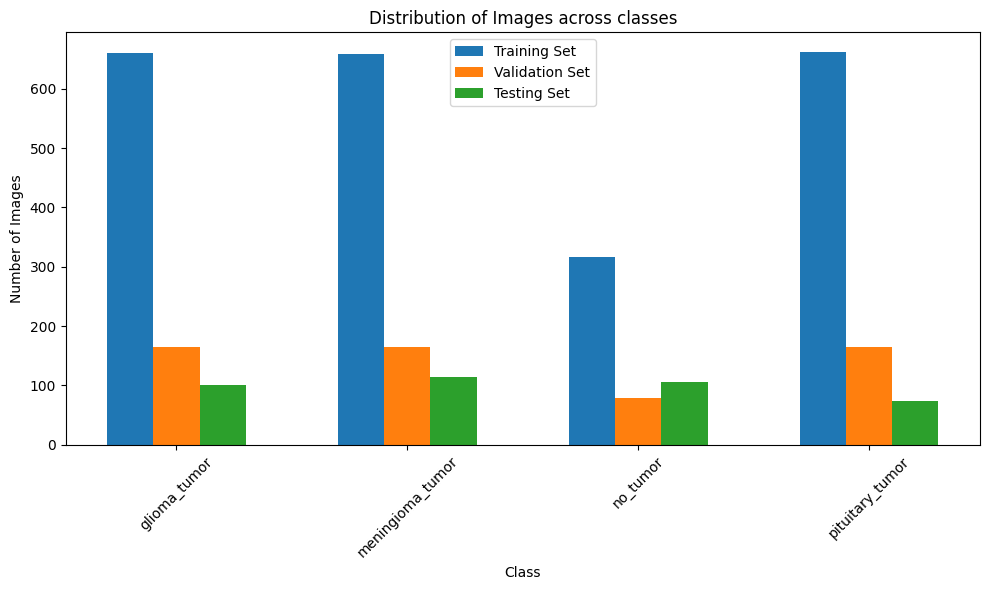

In [17]:
# Visualize the distribution of images across classes
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(class_names))

plt.bar(index, train_images, bar_width, label='Training Set')
plt.bar(index + bar_width, validation_images, bar_width, label='Validation Set')
plt.bar(index + 2 * bar_width, test_images, bar_width, label='Testing Set')

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(index + bar_width, class_names, rotation=45)
plt.legend()
plt.title("Distribution of Images across classes")
plt.tight_layout()
plt.savefig(image_path("Distribution of Images across classes.png"))

plt.show()

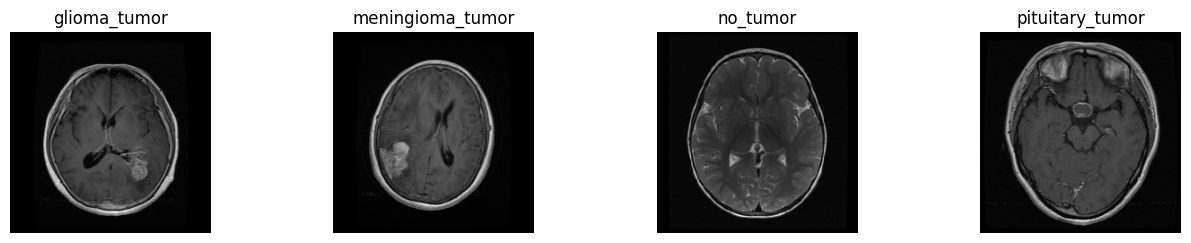

In [18]:
plt.figure(figsize=(16, 12))

fileNames = ['glioma_tumor/gg (10).jpg', 'meningioma_tumor/m (108).jpg', 'no_tumor/image (16).jpg', 'pituitary_tumor/p (12).jpg']
fileLabels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

for i in range(4):
    ax = plt.subplot(4, 4, i + 1)
    img = mpimg.imread(train_dir +"/"+ fileNames[i])
    img = cv2.resize(img, (h, w))
    plt.imshow(img)
    plt.title(fileLabels[i])
    plt.axis("off")
    plt.savefig(image_path("Different classes of tumours.png"))

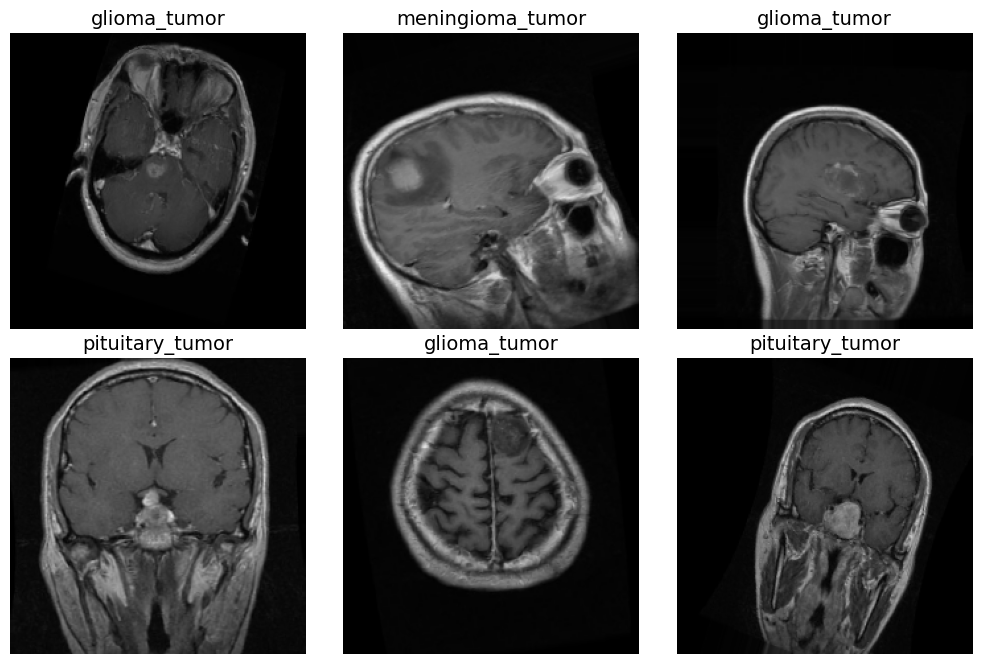

In [19]:
images, classes = next(train_generator)
class_idxs = np.argmax(classes, axis=-1)
labels = [class_names[idx] for idx in class_idxs]

display_six_images(images, labels,"Images after augmentation")

# Step 3: Model Creation

## **InceptionResNetV2**

`InceptionResNetV2` is an advanced model that combines the strengths of two well-known architectures: the `Inception` network and the `ResNet` architecture.

* The `Inception` module allows the network to have multiple filter sizes at each layer, enabling the model to capture a variety of patterns and features from different scales in the image. This results in a more versatile model that can process images in a more sophisticated manner.

* `ResNet` (Residual Networks) introduces skip connections that allow the model to skip one or more layers during the training process. This enables deeper networks to be trained more effectively by mitigating the vanishing gradient problem and allowing information to flow more easily through the network.

`InceptionResNetV2` merges these two approaches, leveraging both multi-scale feature extraction and efficient gradient flow. This results in an architecture capable of achieving very high performance in complex image classification tasks like brain tumour detection.

### Creating the Model

In [20]:
# Load InceptionResNetV2
InceptionRN = InceptionResNetV2(weights="imagenet",
                              include_top=False,
                              input_shape=(224,224,3))

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [21]:
for layer in InceptionRN.layers:# Iterating through each layer in the InceptionRN model.
    layer.trainable = False     # Setting each layer's 'trainable' attribute to False, which ensures that the weights of these layers will not be updated during training.

In [22]:
# define model
model_IRN = create_model(InceptionRN,"_IRN")

model_IRN.summary()

Model: "Brain-Tumour-Classification_IRN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ ?                      │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_1                       │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,336,736 (207.28 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 54,336,736 (207.28 MB)

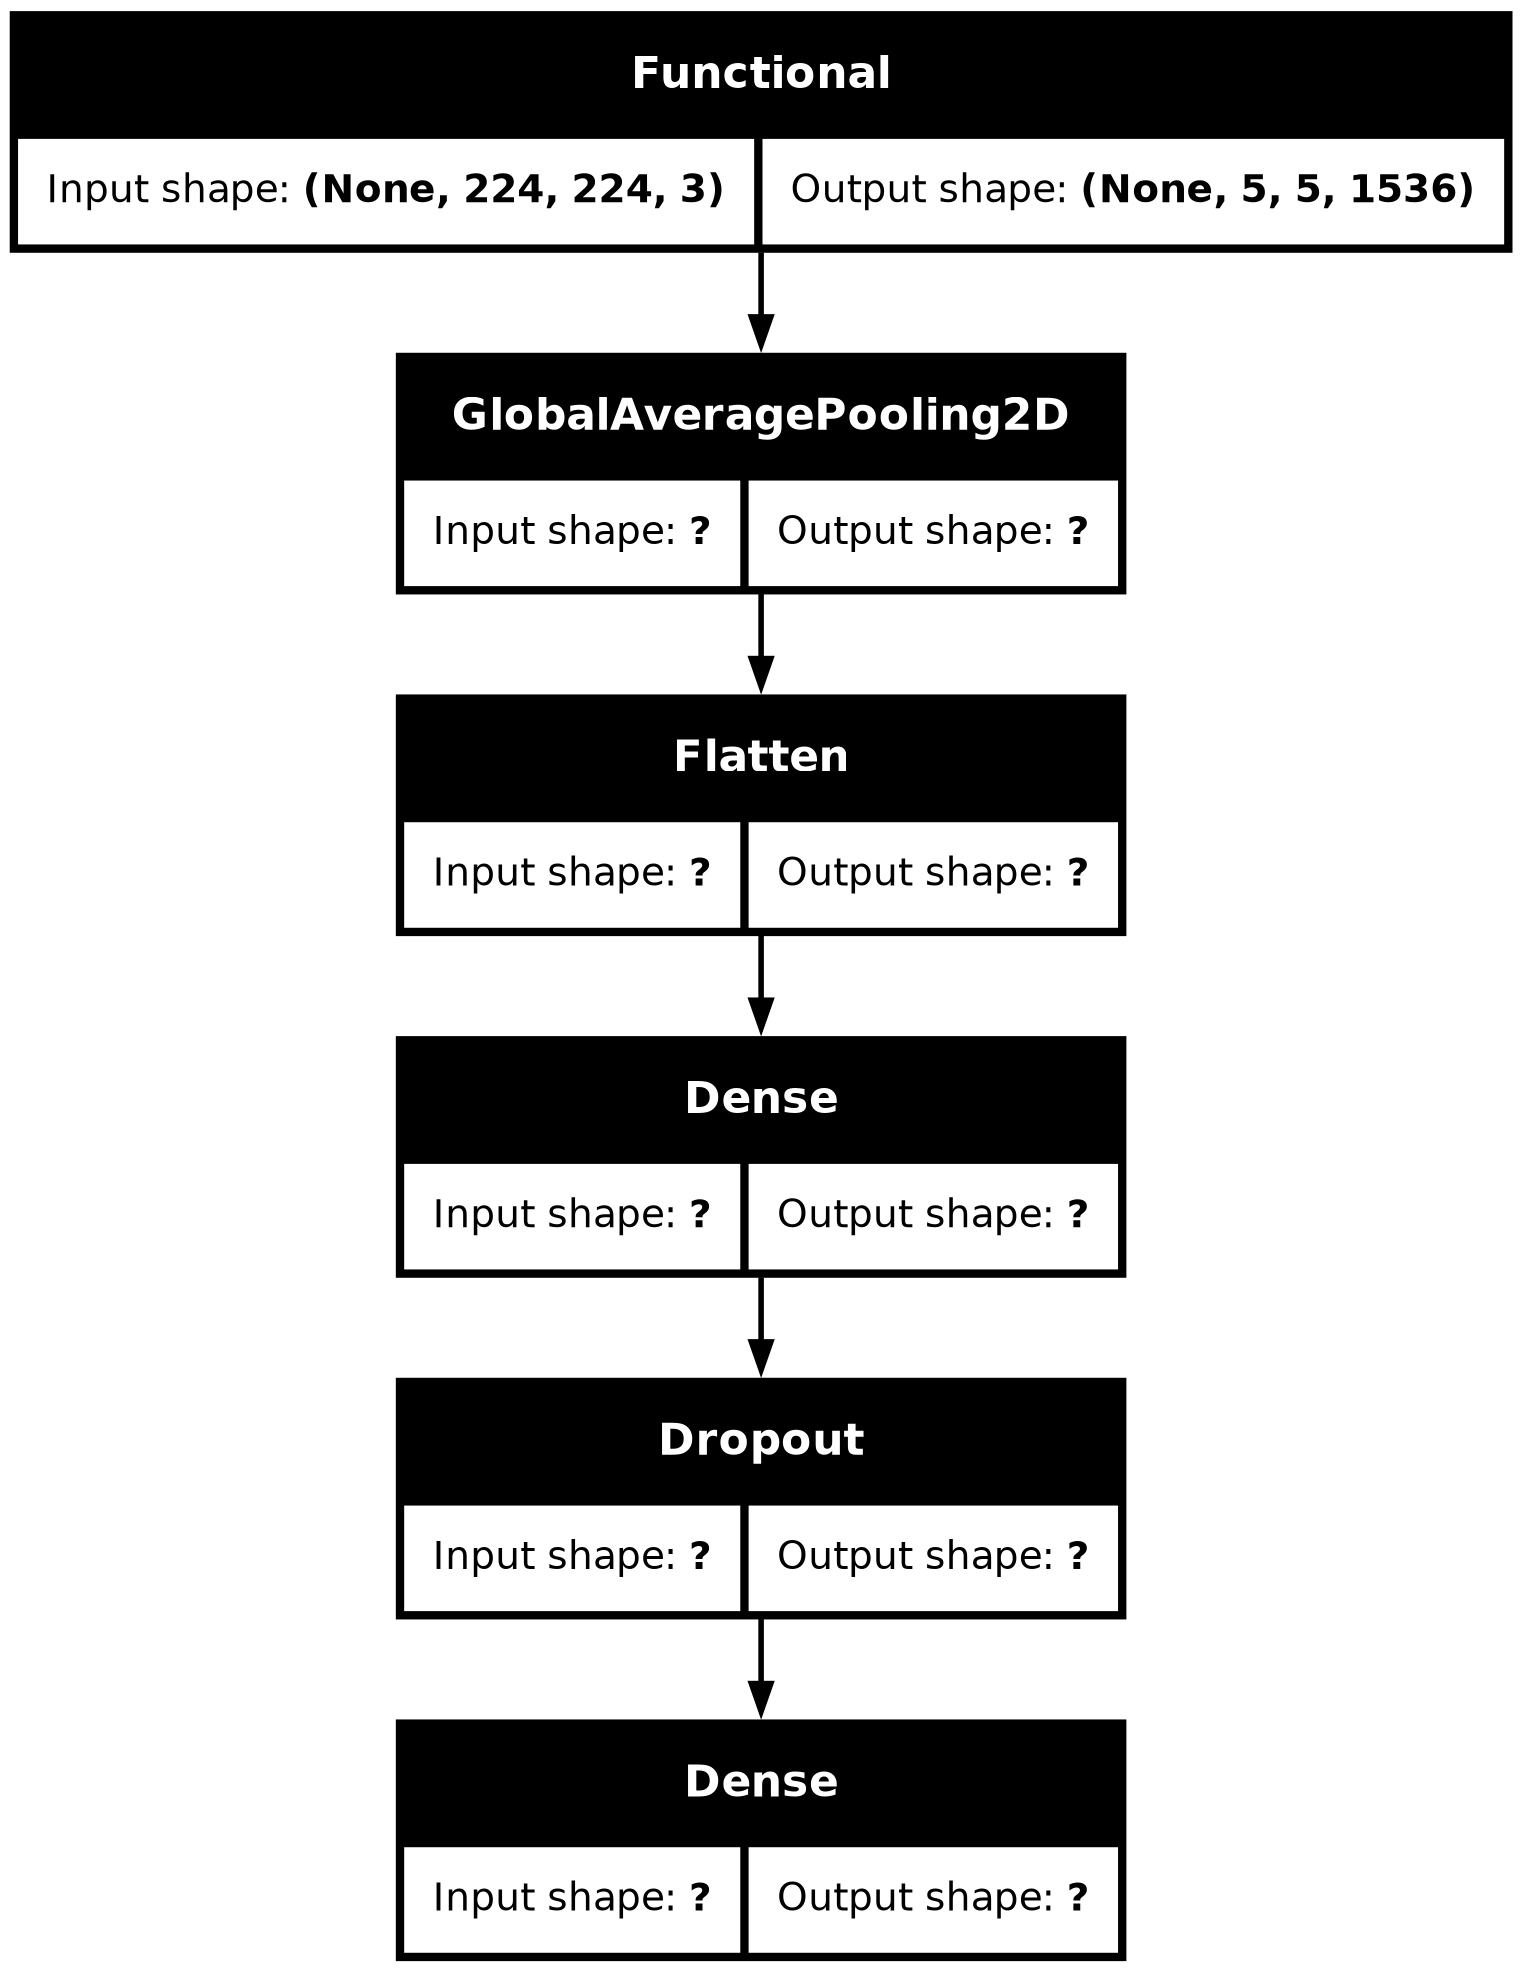

In [23]:
# Plot the model architecture and save it to an image file
plot_model(model_IRN, to_file=image_path(main_model_name+"_IRN.png"), show_shapes=True)

### Compile Model

In [24]:
# Compile the model with specified loss function, optimizer, and metrics
model_IRN.compile(
    loss='categorical_crossentropy',# Categorical cross-entropy loss for multi-class classification
    optimizer=Adam(0.001),          # Adam optimizer with a learning rate of 0.001
    metrics=["accuracy"]            # Monitor the accuracy metric during training
)

### Callbacks

Callbacks are functions or objects in deep learning that are executed at certain stages during the training process. They help manage the training loop, allowing to monitor the training process, adjust model parameters, or save the best model.

In this project, 2 primary callbacks are used: `ReduceLROnPlateau` and `ModelCheckpoint`. 

1. `ReduceLROnPlateau` Callback
* The ReduceLROnPlateau callback is used to adjust the learning rate dynamically based on the model's performance during training. It helps optimize the learning rate, which is a critical hyperparameter in training deep learning models.

2. `ModelCheckpoint` Callback
* The ModelCheckpoint callback is used to save the model at specific points during training. This ensures that the model with the best performance on the validation data is saved, preventing potential loss of valuable progress.

In [25]:
# Create a ReduceLROnPlateau callback with the following parameters:
# This callback monitors the validation accuracy and adjusts the learning rate when the validation accuracy plateaus
lr_reduction_IRN = ReduceLROnPlateau(monitor='val_accuracy',    # Monitors the validation accuracy to decide when to reduce the learning rate.
                                            patience=3,     # Number of epochs with no improvement after which learning rate will be reduced
                                            verbose=1,      # Verbosity level. 1 for updating messages, 0 for silence.
                                            factor=0.5,     # Learning rate will be reduced to half. New_lr = lr * factor
                                            min_lr=0.00001  # Lower bound on the learning rate. It won't reduce the learning rate below this value
                                 )

In [26]:
checkpoint_IRN = ModelCheckpoint(model_path(main_model_name+"_IRN.keras"), save_best_only=True,verbose=1)

In [27]:
# Store the ReduceLROnPlateau callback in a list.
# This list can be passed to a training session.
cbs_IRN = [lr_reduction_IRN, checkpoint_IRN]

### Train the Model

In [28]:
history_IRN = model_IRN.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=cbs_IRN,
                    shuffle=True
                    )

Epoch 1/25


I0000 00:00:1733878806.125094      92 service.cc:145] XLA service 0x781780001d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733878806.125143      92 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733878806.125147      92 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/77 ━━━━━━━━━━━━━━━━━━━━ 44:06 35s/step - accuracy: 0.2000 - loss: 2.2826

I0000 00:00:1733878822.014147      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.5080 - loss: 1.2293
Epoch 1: val_loss improved from inf to 0.78938, saving model to /kaggle/working/Models/Brain-Tumour-Classification_IRN.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 101s 871ms/step - accuracy: 0.5092 - loss: 1.2259 - val_accuracy: 0.6632 - val_loss: 0.7894 - learning_rate: 0.0010
Epoch 2/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.7215 - loss: 0.6889
Epoch 2: val_loss improved from 0.78938 to 0.67310, saving model to /kaggle/working/Models/Brain-Tumour-Classification_IRN.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 35s 430ms/step - accuracy: 0.7217 - loss: 0.6886 - val_accuracy: 0.7330 - val_loss: 0.6731 - learning_rate: 0.0010
Epoch 3/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.7566 - loss: 0.6373
Epoch 3: val_loss did not improve from 0.67310
77/77 ━━━━━━━━━━━━━━━━━━━━ 34s 405ms/step - accuracy: 0.7565 - loss: 0.6371 - val_accuracy: 0.7033 - val_loss: 0.7164 - learning_rate: 0.0010
Epoch 4/25
77/77 ━━━━━━━━

In [29]:
# Save the model to a file
# model_IRN.save(model_path(main_model_name+'_final_IRN.keras'))

## VGG16 and VGG19
* The VGG models (VGG16 and VGG19) are convolutional neural networks known for their simple and deep architecture, which leads to a high degree of accuracy in image classification. Both VGG16 and VGG19 follow a similar architecture, differing only in the number of convolutional layers. VGG16 has 16 layers, and VGG19 has 19 layers, making VGG19 slightly deeper and more capable of capturing finer details in the images.

## **VGG16**

### Creating the Model

In [30]:
# Load VGG16
VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [31]:
for layer in VGG16.layers:
    layer.trainable = False

In [32]:
# define model
model_VGG16 = create_model(VGG16,"_VGG16")

model_VGG16.summary()

Model: "Brain-Tumour-Classification_VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_1                       │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

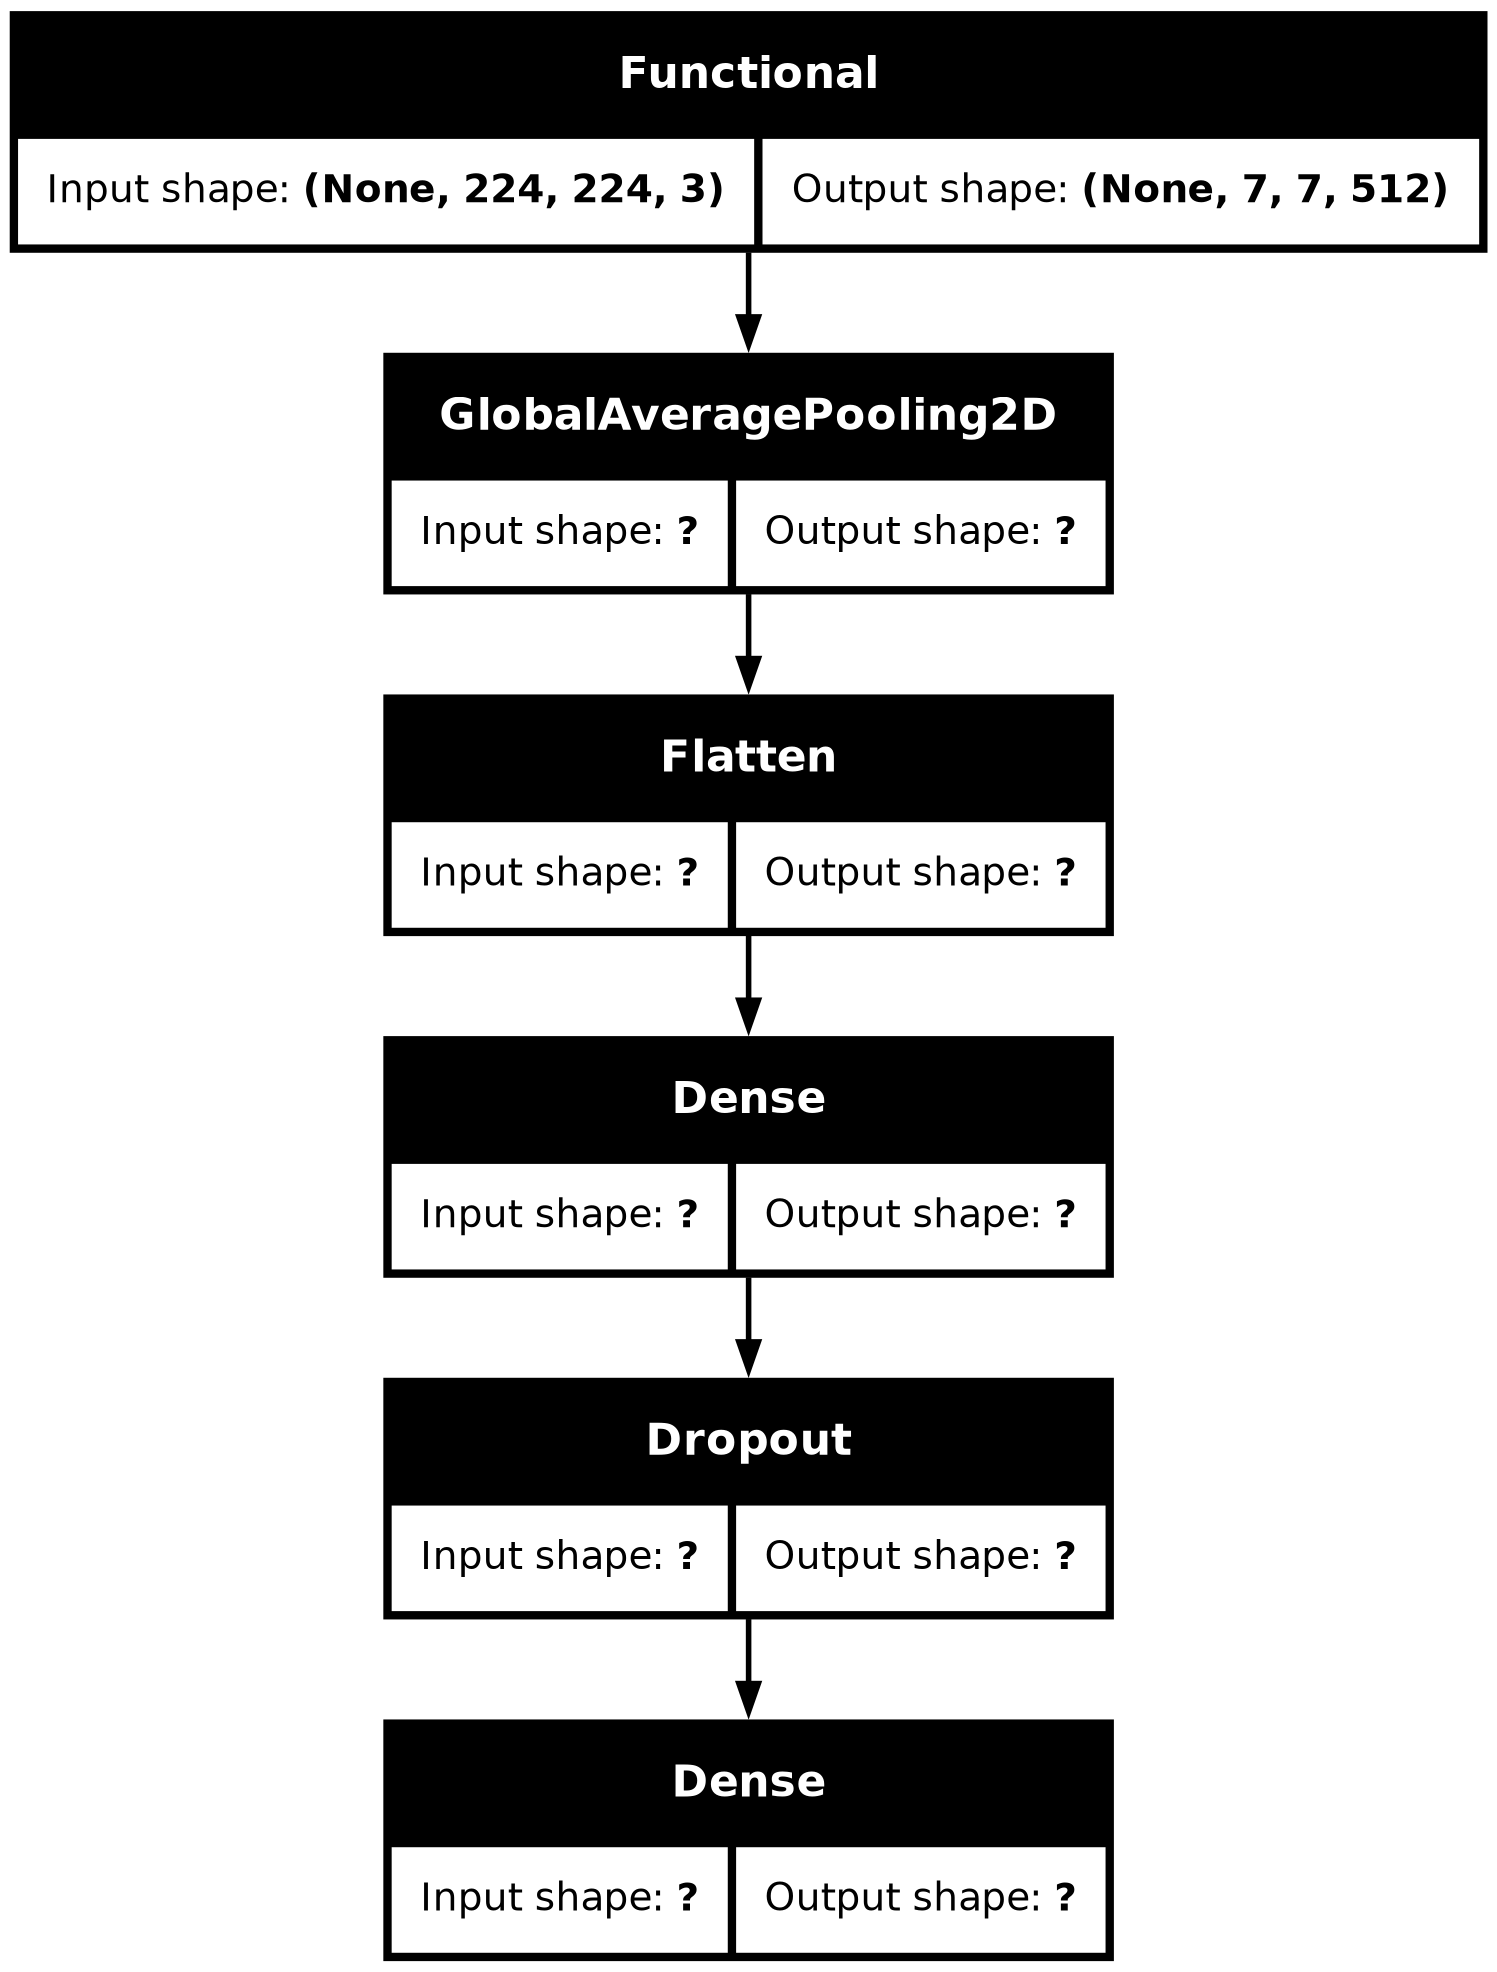

In [33]:
# Plot the model architecture and save it to an image file
plot_model(model_VGG16, to_file=image_path(main_model_name+"_VGG16.png"), show_shapes=True)

### Compile Model

In [34]:
# Compile the model with specified loss function, optimizer, and metrics
model_VGG16.compile(
    loss='categorical_crossentropy',# Categorical cross-entropy loss for multi-class classification
    optimizer=Adam(0.001),          # Adam optimizer with a learning rate of 0.001
    metrics=["accuracy"]            # Monitor the accuracy metric during training
)

### Callbacks

In [35]:
# Create a ReduceLROnPlateau callback with the following parameters:
# This callback monitors the validation accuracy and adjusts the learning rate when the validation accuracy plateaus
lr_reduction_VGG16 = ReduceLROnPlateau(monitor='val_accuracy',    # Monitors the validation accuracy to decide when to reduce the learning rate.
                                            patience=3,     # Number of epochs with no improvement after which learning rate will be reduced
                                            verbose=1,      # Verbosity level. 1 for updating messages, 0 for silence.
                                            factor=0.5,     # Learning rate will be reduced to half. New_lr = lr * factor
                                            min_lr=0.000001  # Lower bound on the learning rate. It won't reduce the learning rate below this value
                                 )

In [36]:
checkpoint_VGG16 = ModelCheckpoint(model_path(main_model_name+"_VGG16.keras"), save_best_only=True,verbose=1)

In [37]:
# Store the ReduceLROnPlateau callback in a list.
# This list can be passed to a training session.
cbs_VGG16 = [lr_reduction_VGG16, checkpoint_VGG16]

### Train the Model

In [38]:
history_VGG16 = model_VGG16.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=cbs_VGG16,
                    shuffle=True
                    )

Epoch 1/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.3765 - loss: 1.3020
Epoch 1: val_loss improved from inf to 1.16662, saving model to /kaggle/working/Models/Brain-Tumour-Classification_VGG16.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 69s 632ms/step - accuracy: 0.3773 - loss: 1.3011 - val_accuracy: 0.4276 - val_loss: 1.1666 - learning_rate: 0.0010
Epoch 2/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.5656 - loss: 1.0650
Epoch 2: val_loss improved from 1.16662 to 1.02742, saving model to /kaggle/working/Models/Brain-Tumour-Classification_VGG16.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 35s 417ms/step - accuracy: 0.5661 - loss: 1.0644 - val_accuracy: 0.5428 - val_loss: 1.0274 - learning_rate: 0.0010
Epoch 3/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.6555 - loss: 0.9053
Epoch 3: val_loss improved from 1.02742 to 0.98466, saving model to /kaggle/working/Models/Brain-Tumour-Classification_VGG16.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 35s 424ms/step - accuracy: 0.6555 - loss: 

In [39]:
# Save the model to a file
# model_VGG16.save(model_path(main_model_name+'_VGG16.keras'))

## **VGG19**

### Creating the Model

In [40]:
# Load VGG19 Net
vgg19 = VGG19(weights="imagenet", include_top=False, input_shape=(224,224,3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [41]:
for layer in vgg19.layers:
    layer.trainable = False

In [42]:
# define model
model_VGG19 = create_model(vgg19,"_VGG19")

model_VGG19.summary()

Model: "Brain-Tumour-Classification_VGG19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_1                       │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

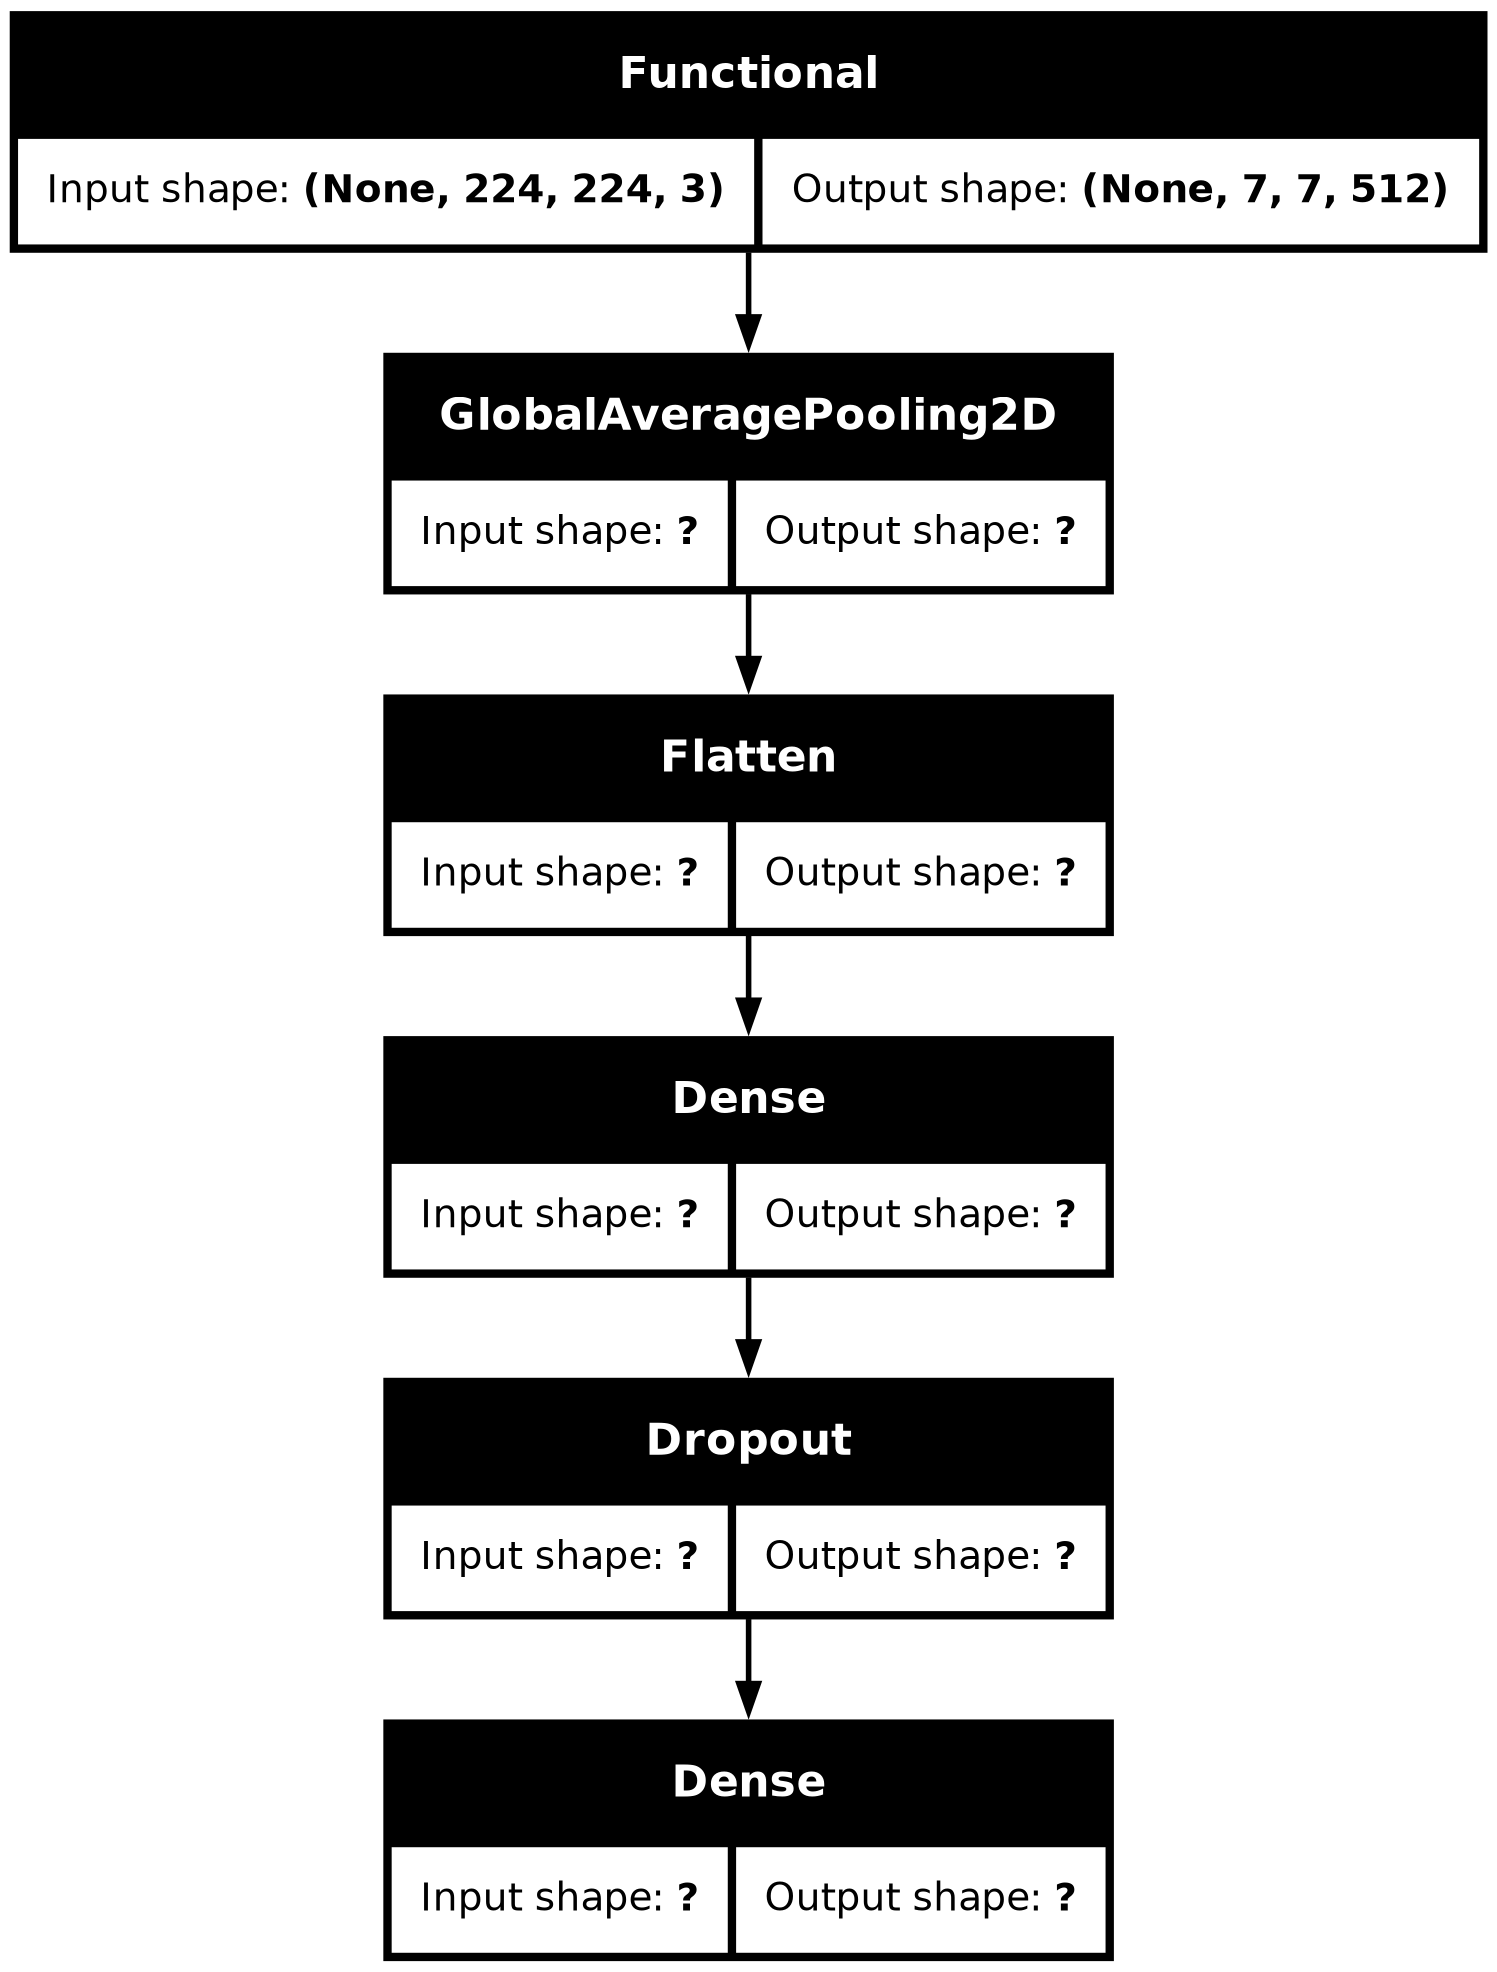

In [43]:
# Plot the model architecture and save it to an image file
plot_model(model_VGG19, to_file=image_path(main_model_name+"_VGG19.png"), show_shapes=True)

### Compile Model

In [44]:
# Compile the model with specified loss function, optimizer, and metrics
model_VGG19.compile(
    loss='categorical_crossentropy',# Categorical cross-entropy loss for multi-class classification
    optimizer=Adam(0.001),          # Adam optimizer with a learning rate of 0.001
    metrics=["accuracy"]            # Monitor the accuracy metric during training
)

### Callbacks

In [45]:
# Create a ReduceLROnPlateau callback with the following parameters:
# This callback monitors the validation accuracy and adjusts the learning rate when the validation accuracy plateaus
lr_reduction_VGG19 = ReduceLROnPlateau(monitor='val_accuracy',    # Monitors the validation accuracy to decide when to reduce the learning rate.
                                            patience=3,     # Number of epochs with no improvement after which learning rate will be reduced
                                            verbose=1,      # Verbosity level. 1 for updating messages, 0 for silence.
                                            factor=0.5,     # Learning rate will be reduced to half. New_lr = lr * factor
                                            min_lr=0.00001  # Lower bound on the learning rate. It won't reduce the learning rate below this value
                                 )

In [46]:
checkpoint_VGG19 = ModelCheckpoint(model_path(main_model_name+"_VGG19.keras"), save_best_only=True,verbose=1)

In [47]:
# Store the ReduceLROnPlateau callback in a list.
# This list can be passed to a training session.
cbs_VGG19 = [lr_reduction_VGG19, checkpoint_VGG19]

### Train the Model

In [48]:
history_VGG19 = model_VGG19.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=cbs_VGG19,
                    shuffle=True
                    )

Epoch 1/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.3169 - loss: 1.3567
Epoch 1: val_loss improved from inf to 1.23060, saving model to /kaggle/working/Models/Brain-Tumour-Classification_VGG19.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 40s 446ms/step - accuracy: 0.3179 - loss: 1.3558 - val_accuracy: 0.3909 - val_loss: 1.2306 - learning_rate: 0.0010
Epoch 2/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.5045 - loss: 1.1469
Epoch 2: val_loss improved from 1.23060 to 1.14184, saving model to /kaggle/working/Models/Brain-Tumour-Classification_VGG19.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 34s 411ms/step - accuracy: 0.5048 - loss: 1.1464 - val_accuracy: 0.4799 - val_loss: 1.1418 - learning_rate: 0.0010
Epoch 3/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.5619 - loss: 1.0385
Epoch 3: val_loss improved from 1.14184 to 1.09332, saving model to /kaggle/working/Models/Brain-Tumour-Classification_VGG19.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 34s 410ms/step - accuracy: 0.5623 - loss: 

In [49]:
# Save the model to a file
# model_VGG19.save(model_path(main_model_name+'_VGG19.keras'))

# Step 4: Evaluate: Plot the Graphs

## Accuracy/Loss Graphs

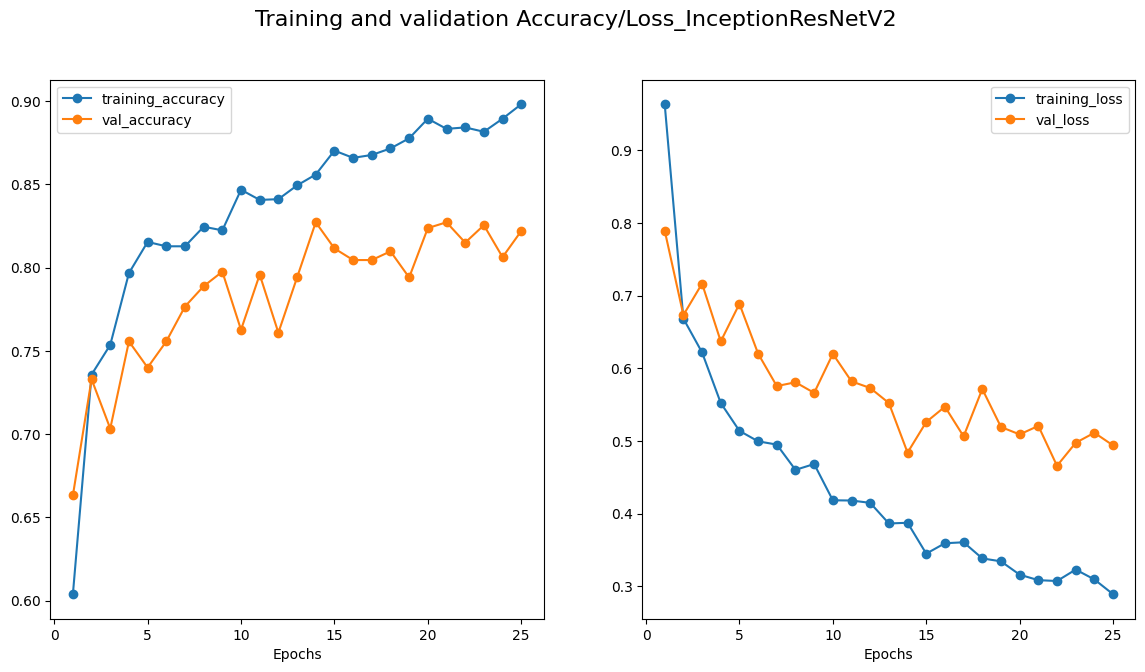

In [50]:
plot_metric(history_IRN, "InceptionResNetV2")

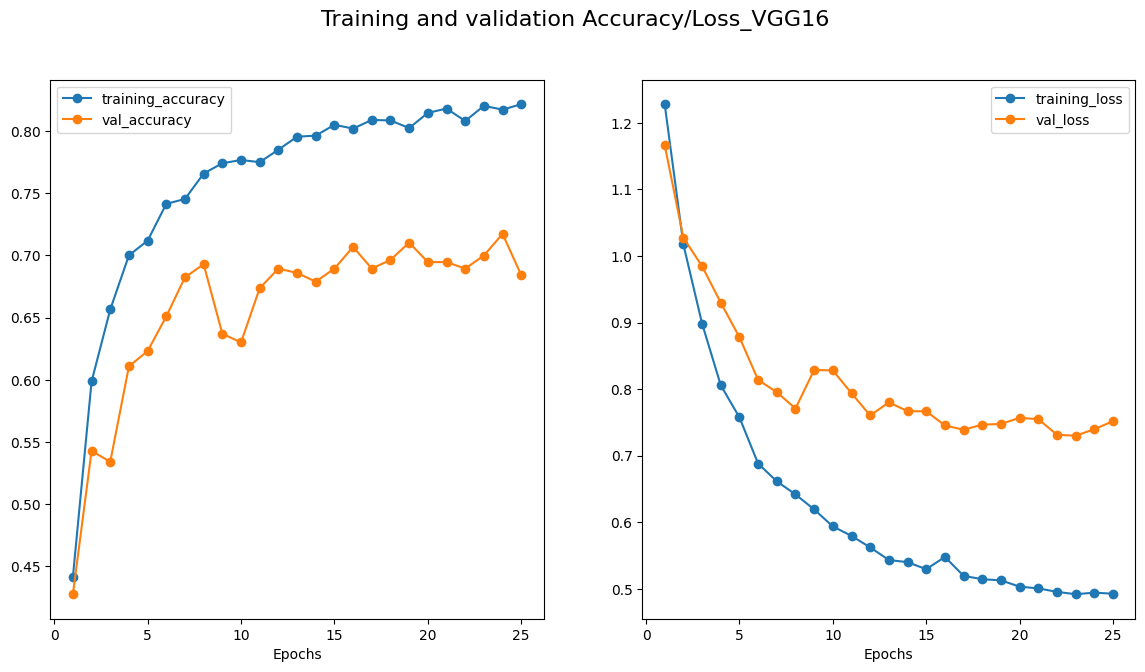

In [51]:
plot_metric(history_VGG16,"VGG16")

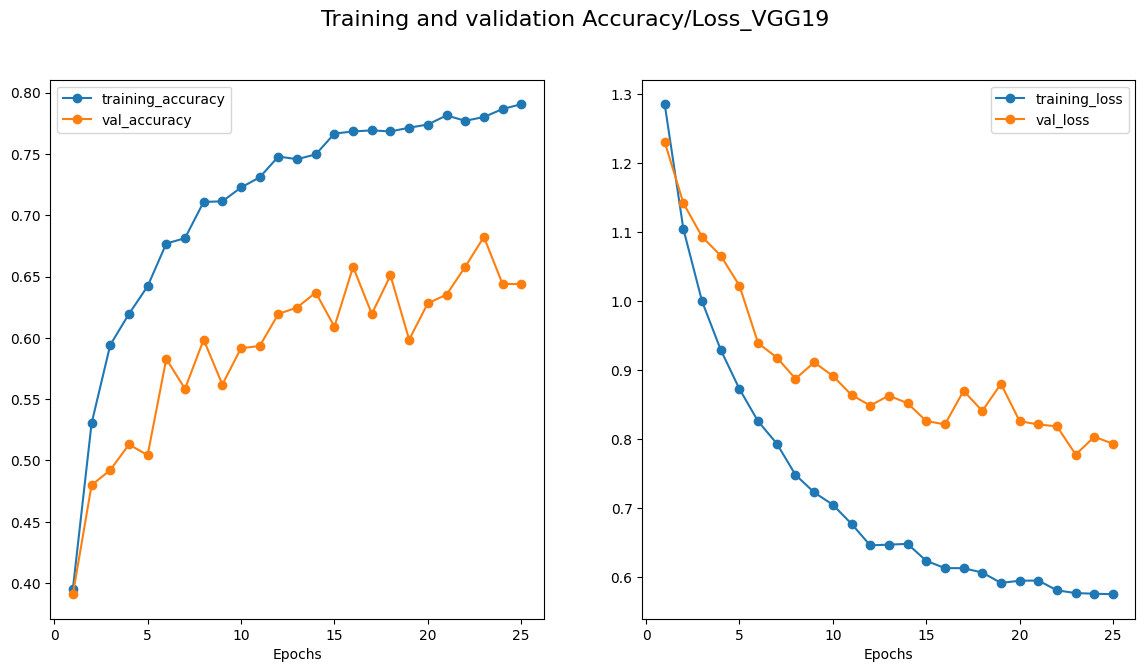

In [52]:
plot_metric(history_VGG19, "VGG19")

## Training, Validation, Testing Accuracy

In [53]:
train_loss_IRN, train_acc_IRN = model_IRN.evaluate(train_generator)
valid_loss_IRN, valid_acc_IRN   = model_IRN.evaluate(validation_generator)
test_loss_IRN, test_acc_IRN  = model_IRN.evaluate(test_generator)

train_loss_VGG16, train_acc_VGG16 = model_VGG16.evaluate(train_generator)
valid_loss_VGG16, valid_acc_VGG16   = model_VGG16.evaluate(validation_generator)
test_loss_VGG16, test_acc_VGG16  = model_VGG16.evaluate(test_generator)

train_loss_VGG19, train_acc_VGG19 = model_VGG19.evaluate(train_generator)
valid_loss_VGG19, valid_acc_VGG19   = model_VGG19.evaluate(validation_generator)
test_loss_VGG19, test_acc_VGG19  = model_VGG19.evaluate(test_generator)

77/77 ━━━━━━━━━━━━━━━━━━━━ 29s 380ms/step - accuracy: 0.9039 - loss: 0.2646
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 330ms/step - accuracy: 0.8005 - loss: 0.5531
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 656ms/step - accuracy: 0.6428 - loss: 1.1059
77/77 ━━━━━━━━━━━━━━━━━━━━ 26s 340ms/step - accuracy: 0.8308 - loss: 0.4764
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 313ms/step - accuracy: 0.7359 - loss: 0.7253
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 456ms/step - accuracy: 0.5466 - loss: 1.4162
77/77 ━━━━━━━━━━━━━━━━━━━━ 27s 346ms/step - accuracy: 0.8020 - loss: 0.5526
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 325ms/step - accuracy: 0.6593 - loss: 0.8225
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 0.5225 - loss: 1.7625


In [54]:
# Create a dictionary with model names and accuracies
data = {
    "Model": ["InceptionResNetV2", "VGG16", "VGG19"],
    "Training Accuracy (%)": [train_acc_IRN * 100, train_acc_VGG16 * 100, train_acc_VGG19 * 100],
    "Validation Accuracy (%)": [valid_acc_IRN * 100, valid_acc_VGG16 * 100, valid_acc_VGG19 * 100],
    "Test Accuracy (%)": [test_acc_IRN * 100, test_acc_VGG16 * 100, test_acc_VGG19 * 100],
}

# Convert the dictionary into a DataFrame
results_df = pd.DataFrame(data)

# Round the accuracy values to 2 decimal places
results_df = results_df.round({"Training Accuracy (%)": 2, "Validation Accuracy (%)": 2, "Test Accuracy (%)": 2})

# Print the table 
print("Model Evaluation Results:")
print(tabulate(results_df, headers='keys', tablefmt='fancy_grid', showindex=False))

Model Evaluation Results:
╒═══════════════════╤═════════════════════════╤═══════════════════════════╤═════════════════════╕
│ Model             │   Training Accuracy (%) │   Validation Accuracy (%) │   Test Accuracy (%) │
╞═══════════════════╪═════════════════════════╪═══════════════════════════╪═════════════════════╡
│ InceptionResNetV2 │                   89.77 │                     81.68 │               66.75 │
├───────────────────┼─────────────────────────┼───────────────────────────┼─────────────────────┤
│ VGG16             │                   83.33 │                     71.73 │               52.28 │
├───────────────────┼─────────────────────────┼───────────────────────────┼─────────────────────┤
│ VGG19             │                   80.32 │                     64.92 │               52.28 │
╘═══════════════════╧═════════════════════════╧═══════════════════════════╧═════════════════════╛


# Step 5: Predictions

In [55]:
images, classes = next(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


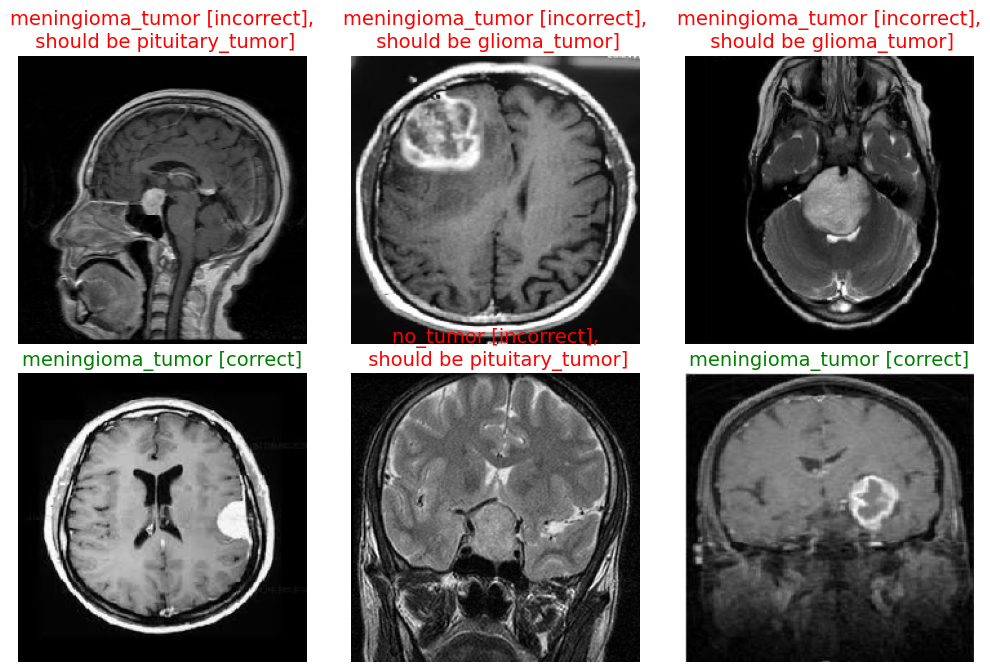

In [56]:
titles_IRN, colors_IRN = predict_titles(images, classes, model_IRN)
display_six_images(images, titles_IRN,"After Prediction using InceptionResNetV2" ,colors_IRN)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


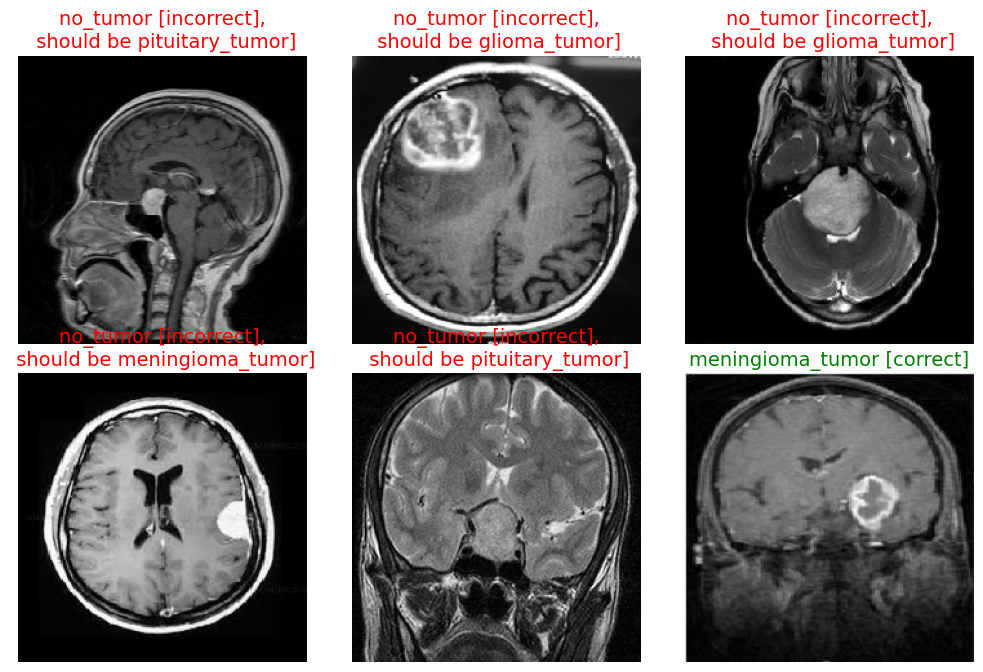

In [57]:
titles_VGG16, colors_VGG16 = predict_titles(images, classes, model_VGG16)
display_six_images(images, titles_VGG16,"After Prediction using VGG16" ,colors_VGG16)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


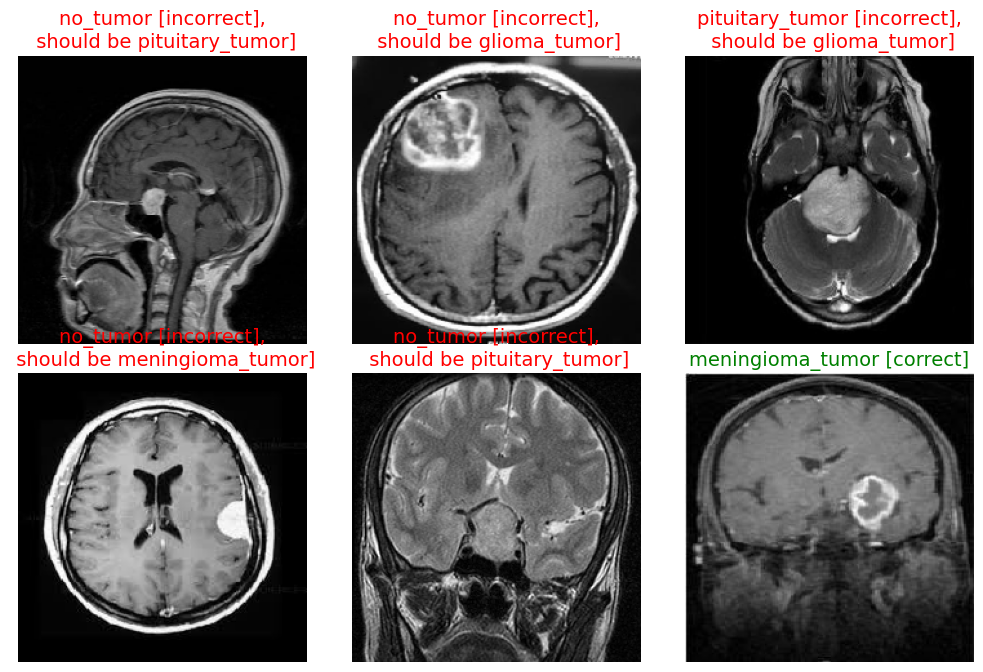

In [58]:
titles_VGG19, colors_VGG19 = predict_titles(images, classes, model_VGG19)
display_six_images(images, titles_VGG19,"After Prediction using VGG19" ,colors_VGG19)